# Import Modules

In [0]:
import matplotlib.pyplot as plt
# from PIL import Image
import cv2
import pandas as pd
import numpy as np
import os
from numpy import asarray

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, Reshape, MaxPooling2D, CuDNNLSTM, Embedding
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss

from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense
# from keras.layers import Flatten

# Data Preparation

In [0]:
# cd '/content/drive/My Drive/SemEval_2020/memotion_analysis_training_data'
cd '/content/drive/My Drive/SemEval_2020/semeval-2020_trialdata'

/content/drive/My Drive/SemEval_2020/semeval-2020_trialdata


## Read CSV Data

In [0]:
PATH_CSV = "data1.csv"
PATH_IMG = "./Meme_images/"
trainX=[]
data = pd.read_csv(PATH_CSV,usecols=[0,2,8]) # header=None 
data.columns = ['Image_name', 'OCR_extracted_text', 'Overall_Sentiment']
data.shape

(914, 3)

In [0]:
data['Overall_Sentiment'].value_counts()

positive           407
neutral            277
very_positive      149
negative            50
very_negative       20
image_and_text       8
text                 2
image                1
Name: Overall_Sentiment, dtype: int64

In [0]:
#delete wrong data
data = data[data['Overall_Sentiment'].isin(['positive','neutral','very_positive','negative','very_negative'])]
data['Overall_Sentiment'].value_counts()

positive         407
neutral          277
very_positive    149
negative          50
very_negative     20
Name: Overall_Sentiment, dtype: int64

## Read Image data

In [0]:
size = 200,200  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in data['Image_name']:
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      error.append(img_name)
  else:
    error.append(img_name)
  print(img.shape, img_name)
print(error)

X = np.array(X)/255   # converting list to array

(200, 200, 3) skeptical_stealing-my-milk.jpg
(200, 200, 3) skeptical_breathing+if+she+has+my+nose.jpg
(200, 200, 3) skeptical_603b3553d88441537f6c65abac8a1cec.jpg
(200, 200, 3) skeptical_e17ae5f069b21df5599460939047d4ae8db9852ea6ce2c277c15eeea6f7928ef.jpg
(200, 200, 3) skeptical_75c34fa1-4d2b-45c1-9bda-5ff0f15d241e.jpg
(200, 200, 3) skeptical_steve-5c00540f46e0fb00018941d4.jpg
(200, 200, 3) skeptical_59921.jpg
(200, 200, 3) skeptical_iqtkv.jpg
(200, 200, 3) skeptical_vegtables-made-on-imgur-skeptical-baby-meme-on-imgur-54337431.png
(200, 200, 3) skeptical_1p65xn.jpg
(200, 200, 3) skeptical_bitch-how-da-hell-she-like-you-youra-asshole-make-54337407.png
(200, 200, 3) skeptical_skeptical-baby-meme.jpg
(200, 200, 3) skeptical_funny-skeptical-baby-memes.png
(200, 200, 3) skeptical_d6a7c22c2e42d73ae76cfdcd4e037527--property-manager-humor-property-management-humor.jpg
(200, 200, 3) skeptical_youand-9-other-coworkers-pool-for-lottery-for-yearsand-finallywin-54337404.png
(200, 200, 3) skeptical

In [0]:
data = data[~data['Image_name'].isin(error)] # delete data of error images

Y = data['Overall_Sentiment']
num_class = 5
Y = to_categorical(Y.factorize()[0])

width, height, channels = X.shape[1], X.shape[2], X.shape[3]
data.shape,X.shape,Y.shape

## Or import processed img data

In [0]:
# Import pre-processed image data
# import pickle 

# pickle_out = open("/content/drive/My Drive/SemEval_2020//trial_train_200_200.pickle", "wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/SemEval_2020/pickles/trial_trainY.pickle", "wb")
# pickle.dump(Y, pickle_out)
# pickle_out.close()

# X = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/trial_train_200_200.pickle", "rb"))
# Y = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/trial_trainY.pickle", "rb"))

# Modelling

## Image Data + CNN

In [0]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (722, 200, 200, 3) (722, 5)
Test ((181, 200, 200, 3), (181, 5))
Train 0.0 1.0 0.48231554962613044 0.33994291592404074
Test 0.0 1.0 0.46073626656555744 0.33864667521435543


In [0]:
# reshape dataset to have a single channel
# width, height, channels = trainX.shape[1], trainX.shape[2], trainX.shape[3]
# trainX = trainX.reshape((trainX.shape[0], width,height,channels))
# testX = testX.reshape((testX.shape[0], width,height,channels))

# one hot encode target values
# trainY = to_categorical(trainY.factorize()[0])
# testY = to_categorical(testY.factorize()[0])

# create generator (1.0/255.0 = 0.003921568627451)
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True) # standardize

# prepare an iterators to scale images
train_iterator = datagen.flow(trainX, trainY, batch_size=64)
test_iterator = datagen.flow(testX, testY, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

# confirm the scaling works
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batches train=12, test=3
Batch shape=(64, 200, 200, 3), min=0.000, max=1.000


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
# define model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))


model.add(Dense(5, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 99, 99, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 147456)          

In [0]:
# # fit model with generator

# model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=50)

# # evaluate model
# _, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
# print('Test Accuracy: %.3f' % (acc * 100))


results = model.fit(trainX, trainY,
         epochs=50,
         batch_size=64,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY)
         )


Train on 722 samples, validate on 181 samples
Epoch 1/50
722/722 [==============================] - 2s 3ms/sample - loss: 3.6937 - acc: 0.3657 - val_loss: 1.5976 - val_acc: 0.4475
Epoch 2/50
722/722 [==============================] - 2s 3ms/sample - loss: 1.3582 - acc: 0.4391 - val_loss: 1.3883 - val_acc: 0.4586
Epoch 3/50
722/722 [==============================] - 2s 3ms/sample - loss: 1.2776 - acc: 0.4391 - val_loss: 1.3823 - val_acc: 0.3260
Epoch 4/50
722/722 [==============================] - 2s 3ms/sample - loss: 1.2439 - acc: 0.4571 - val_loss: 1.4350 - val_acc: 0.3370
Epoch 5/50
722/722 [==============================] - 2s 3ms/sample - loss: 1.1996 - acc: 0.4765 - val_loss: 1.3609 - val_acc: 0.3425
Epoch 6/50
722/722 [==============================] - 2s 3ms/sample - loss: 1.1219 - acc: 0.5208 - val_loss: 1.3772 - val_acc: 0.3702
Epoch 7/50
722/722 [==============================] - 2s 3ms/sample - loss: 0.9909 - acc: 0.6039 - val_loss: 1.5581 - val_acc: 0.2818
Epoch 8/50
722/7

In [0]:
model.evaluate(testX,testY)

181/181 [==============================] - 0s 1ms/sample - loss: 5.3518 - acc: 0.3425


[5.351830400814667, 0.34254143]

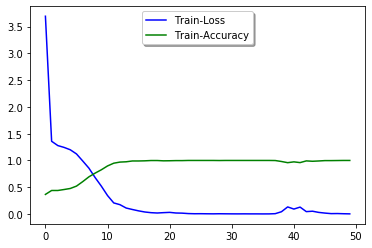

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

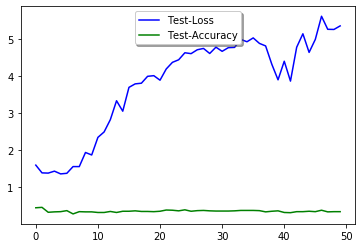

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Text Data + LSTM

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
t = Tokenizer()
X_text = data['OCR_extracted_text']
X_text = [str(i) for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)

3327


In [0]:
encoded_train = t.texts_to_sequences(X_text)
max(list(map(lambda x: len(x), encoded_train)))

190

In [0]:
max_length = 190
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

padded_train[0]

array([1208,  280,   24,  182, 1209,    3,  123,   61,   45,  710,   12,
        394,   40,    6,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [0]:
Y = data['Overall_Sentiment']
num_class = 5
Y = to_categorical(Y.factorize()[0])
len(X_text),len(Y)

(903, 903)

In [0]:
# Train-test Split

trainX, testX, trainY, testY = train_test_split(padded_train, Y, test_size=0.2, random_state=0,stratify=Y)
# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (722, 190) (722, 5)
Test ((181, 190), (181, 5))
Train 0 3326 42.35010205569325 277.76395122714587
Test 0 3310 35.652428031404476 253.24945013095882


In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.1))


model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(5, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
results = model.fit(trainX, trainY, epochs=50, shuffle=True, validation_data=(testX,testY), batch_size=64)

Train on 722 samples, validate on 181 samples
Epoch 1/50
722/722 [==============================] - 1s 736us/sample - loss: 1.3644 - acc: 0.3920 - val_loss: 1.2771 - val_acc: 0.4530
Epoch 2/50
722/722 [==============================] - 0s 309us/sample - loss: 1.2740 - acc: 0.4474 - val_loss: 1.2773 - val_acc: 0.4530
Epoch 3/50
722/722 [==============================] - 0s 240us/sample - loss: 1.2688 - acc: 0.4501 - val_loss: 1.2659 - val_acc: 0.4586
Epoch 4/50
722/722 [==============================] - 0s 224us/sample - loss: 1.2146 - acc: 0.4751 - val_loss: 1.2645 - val_acc: 0.4586
Epoch 5/50
722/722 [==============================] - 0s 226us/sample - loss: 1.0026 - acc: 0.6385 - val_loss: 1.4148 - val_acc: 0.4199
Epoch 6/50
722/722 [==============================] - 0s 236us/sample - loss: 0.6733 - acc: 0.7632 - val_loss: 2.0249 - val_acc: 0.3978
Epoch 7/50
722/722 [==============================] - 0s 225us/sample - loss: 0.4462 - acc: 0.8476 - val_loss: 2.0886 - val_acc: 0.3591
Ep

In [0]:
model.evaluate(testX,testY)

181/181 [==============================] - 0s 285us/sample - loss: 4.7727 - acc: 0.3370


[4.772659409770649, 0.33701658]

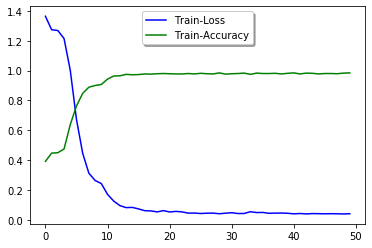

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

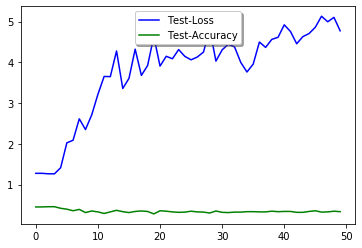

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

# Manual Test

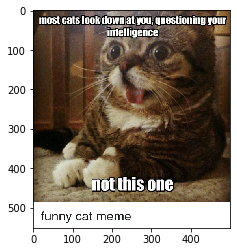

In [0]:
test_img = cv2.cvtColor(cv2.imread(PATH_IMG+data['Image_name'][814]), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [0]:
data[800:814]

,Image_name,OCR_extracted_text,Overall_Sentiment
810,cat_U_445h9FD0D491.jpg,,positive
811,cat_U_447dont-just-stand-there-funny-catmemes-...,,positive
812,cat_U_175Human-Cat-Meme190.jpg,,neutral
813,cat_U_9h58F020A6.jpg,,positive
814,cat_U_415most-cats-look-down-at-you-questionin...,most cats look down at you questioning our in...,very_positive
815,cat_U_345amazing-cat-memes.jpg,,very_positive
816,cat_U_947900e07e24b105978a407d0dbe0121eda76df5...,,positive
817,cat_U_52funny-cat-memes-images.jpg,,very_positive
818,cat_U_37704-facebook.comcat.addicts.jpg,,positive
819,cat_U_23831931510.jpg,,very_positive


In [0]:
#prediction
temp = model.predict(X[800:814].reshape(-1,200,200,3))
temp_pre = [np.argmax(i) for i in temp]
temp_pre

[3, 3, 2, 3, 3, 0, 3, 0, 3, 0, 3, 3, 2, 3]

In [0]:
#Ground Truth
temp = Y[800:814]
temp_truth = [np.argmax(i) for i in temp]
temp_truth

[3, 3, 2, 3, 0, 0, 3, 0, 3, 0, 3, 3, 2, 3]

In [0]:
accuracy_score(temp_pre, temp_truth)

0.9285714285714286

In [0]:
model.evaluate(X[800:814],Y[800:814])

14/14 [==============================] - 0s 1ms/sample - loss: 0.3016 - acc: 0.9286


[0.3016470968723297, 0.9285714]